In [1]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob
import os

## Template Matching

Text(0.5, 1.0, 'Coca Cola template')

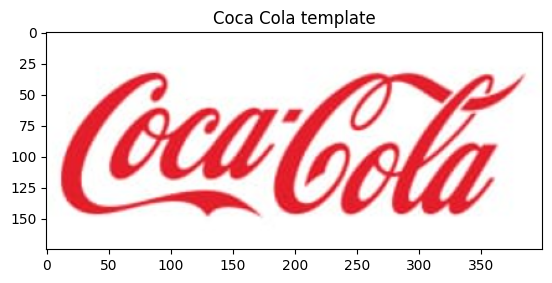

In [2]:
# Show template: 

template_path = "data/template/pattern.png"

template_bgr = cv.imread(template_path)
template_rgb = cv.cvtColor(template_bgr, cv.COLOR_BGR2RGB)

plt.figure()
plt.imshow(template_rgb)
plt.title("Coca Cola template")

Text(0.5, 1.0, 'Coca Cola template binary mask')

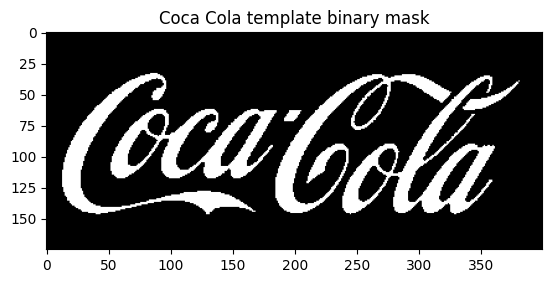

In [3]:
# Mascara binaria del template: 

template_gray = cv.cvtColor(template_bgr, cv.COLOR_BGR2GRAY)

_, template_binary_mask = cv.threshold(template_gray, 127, 255, cv.THRESH_BINARY_INV)

plt.figure()
plt.imshow(template_binary_mask, cmap='gray')
plt.title("Coca Cola template binary mask")

Text(0.5, 1.0, 'Coca Cola template cropped')

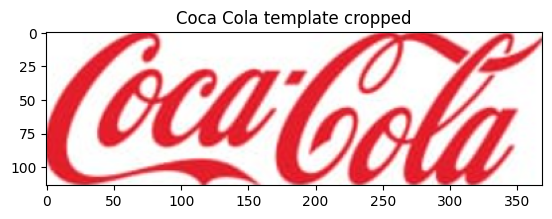

In [4]:
# Recorto al rededor de la mascara para remover sectores del template que no nos dan informacion
non_zero_indices = np.nonzero(template_binary_mask)

# Obtener los valores mínimos y máximos de x e y
y_min, y_max = np.min(non_zero_indices[0]), np.max(non_zero_indices[0])
x_min, x_max = np.min(non_zero_indices[1]), np.max(non_zero_indices[1])

# Paso 5: Recortar la imagen original usando los límites encontrados
croped_template_mask = template_binary_mask[y_min:y_max+1, x_min:x_max+1]
croped_template_rgb = template_rgb[y_min:y_max+1, x_min:x_max+1, :]

plt.figure()
plt.imshow(croped_template_rgb)
plt.title("Coca Cola template cropped")

Text(0.5, 1.0, 'Coca Cola template Canny')

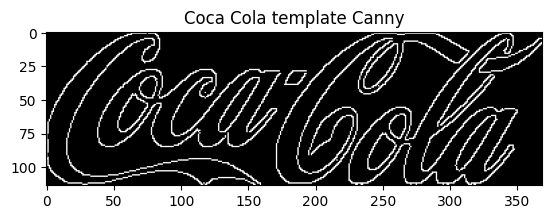

In [5]:
# Utilizamos canny para trabajar directamente con los bordes:

croped_template_canny = cv.Canny(croped_template_rgb, 100, 220)

plt.figure()
plt.imshow(croped_template_canny, cmap='gray')
plt.title("Coca Cola template Canny")

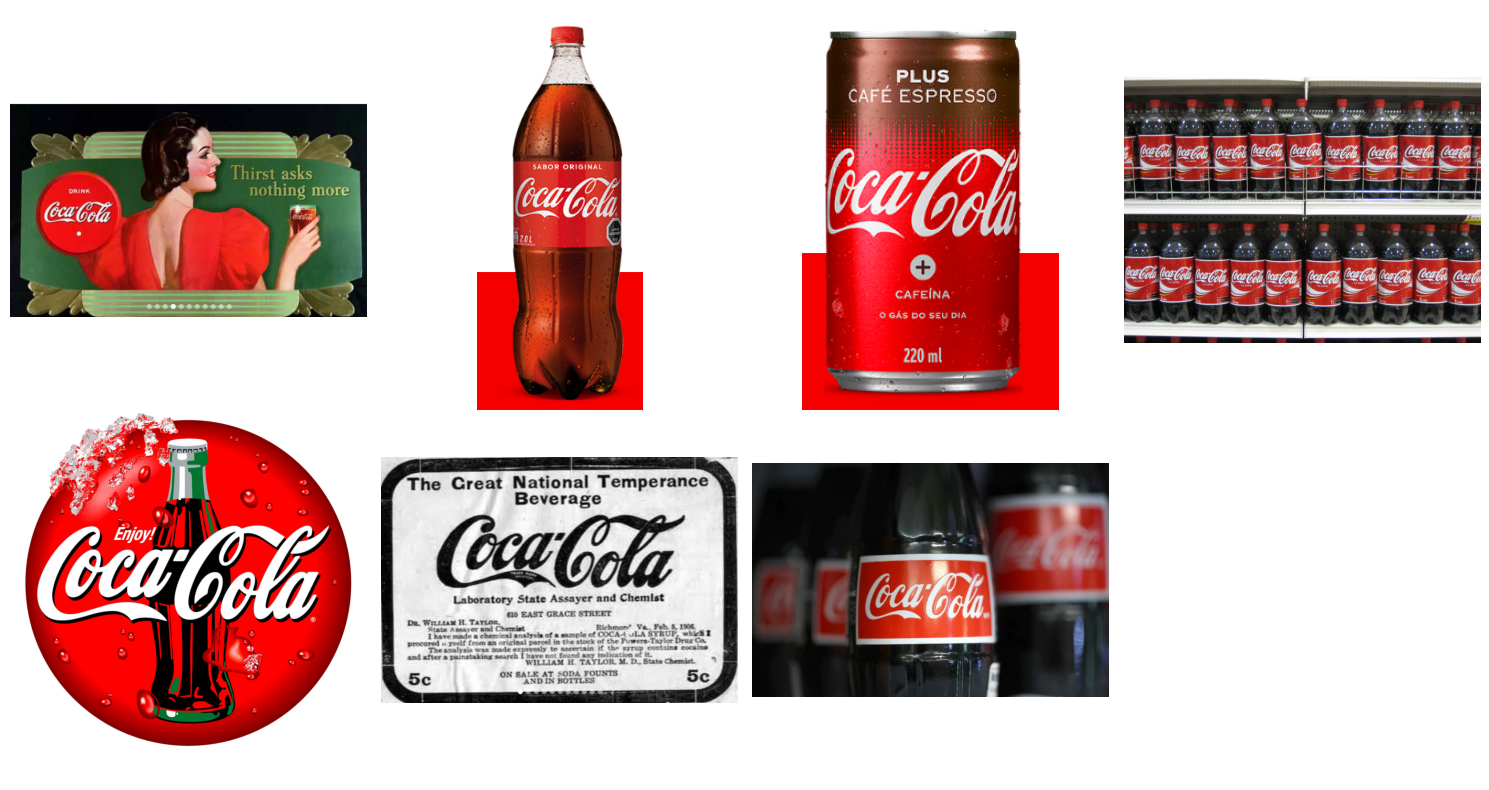

In [6]:
# Show images: 
image_folder = 'data/images/'

image_paths = glob.glob(f'{image_folder}/*')[:7]
num_images = len(image_paths)

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i in range(8):  
    if i < num_images:
        # Read the image
        image = cv.imread(image_paths[i])
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        # Plot the image
        axes[i].imshow(image_rgb)
        axes[i].axis('off')  # Turn off axis labels
    else:
        # Hide the empty subplot
        axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()


### Ejercicio 1

Obtener una detección del logo en cada imagen sin falsos positivos

In [41]:
def resize_with_aspect_ratio(image, width=None, height=None, inter=cv.INTER_AREA):

    # Grab the dimensions of the image
    (h, w) = image.shape[:2]
    
    # If both the width and height are None, then return the original image
    if width is None and height is None:
        return image
    
    # If the width is None, calculate the ratio of the height and construct the dimensions
    if width is None:
        ratio = height / float(h)
        dim = (int(w * ratio), height)
    
    # If the height is None, calculate the ratio of the width and construct the dimensions
    else:
        ratio = width / float(w)
        dim = (width, int(h * ratio))
    
    # Resize the image
    resized = cv.resize(image, dim, interpolation=inter)
    
    return resized, ratio

def resize_coords(coords, x_ratio, y_ratio):
    return [(int(top_x * x_ratio), int(top_y * y_ratio), int(end_x * x_ratio), int(end_y * y_ratio)) for (top_x, top_y, end_x, end_y) in coords]



def get_matching(image, template, method, res_range = (0.05, 0.65)):

    if len(template.shape)>2:
        template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

    
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image_canny = cv.Canny(image_gray, 50, 200)
    w, h = image_gray.shape
    img_salida = image.copy()
    
    scale_factors = np.linspace(res_range[0], res_range[1], num=10)

    found = None
    for scale in scale_factors:
        
        template_canny_resized = cv.resize(template, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA)
        
        if template_canny_resized.shape[0] > w  or template_canny_resized.shape[1] > h:
            continue

        result = cv.matchTemplate(image_canny, template_canny_resized, method)

        _, max_val, _, max_loc= cv.minMaxLoc(result)
        if found is None or max_val > found[0]:
            h_resize, w_resize = template_canny_resized.shape
            found = (max_val, max_loc, w_resize, h_resize)
    
    (_, maxloc, w_out, h_out) = found
    (top_x, top_y) = (int(maxloc[0]), int(maxloc[1]))
    (end_x, end_y) = (int(maxloc[0] + w_out), int(maxloc[1] + h_out))

    cv.rectangle(img_salida, (top_x, top_y), (end_x, end_y), (255, 0, 0), 2)

    return img_salida

(0.46109074354171753, (709, 158), 74, 23)
(0.46109074354171753, (709, 158), 74, 23)
(0.46109074354171753, (709, 158), 74, 23)
(0.46109074354171753, (709, 158), 74, 23)
(0.46109074354171753, (709, 158), 74, 23)
(0.46109074354171753, (709, 158), 74, 23)
(0.46109074354171753, (709, 158), 74, 23)


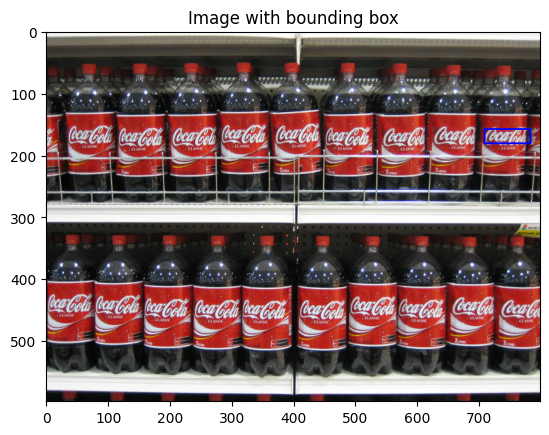

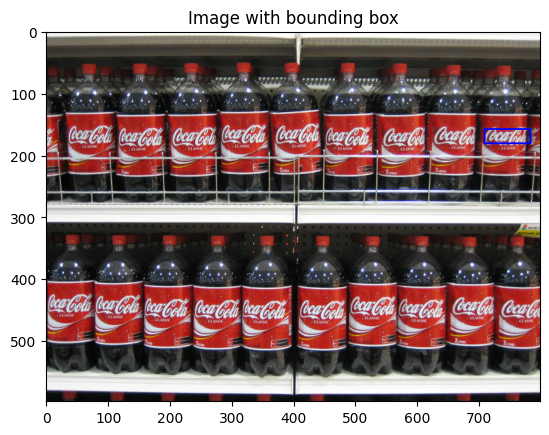

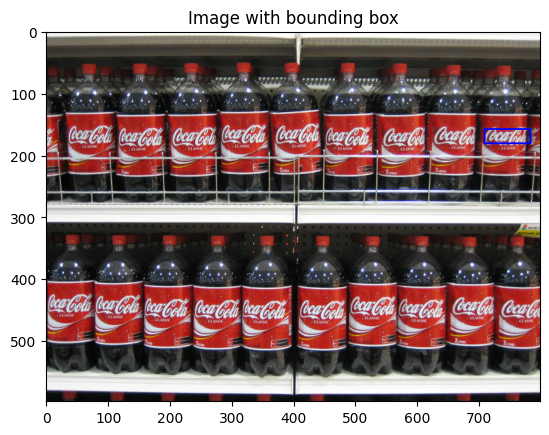

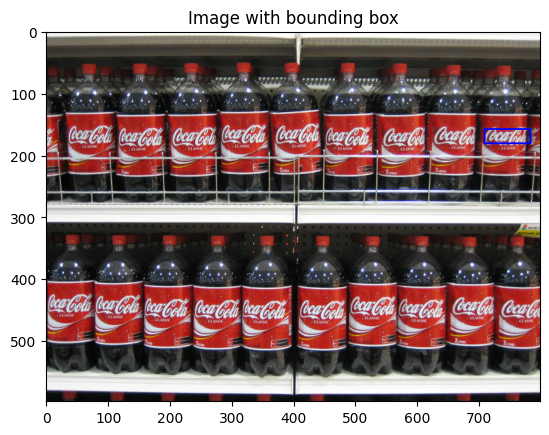

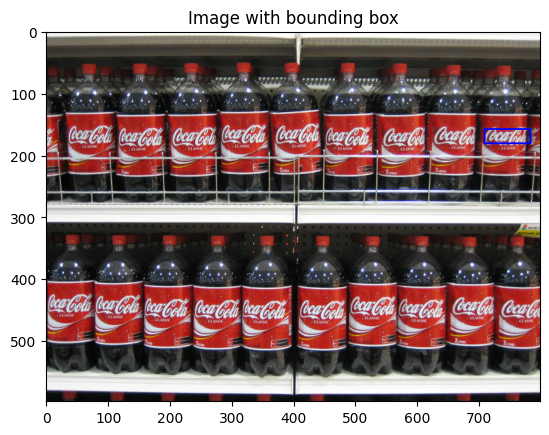

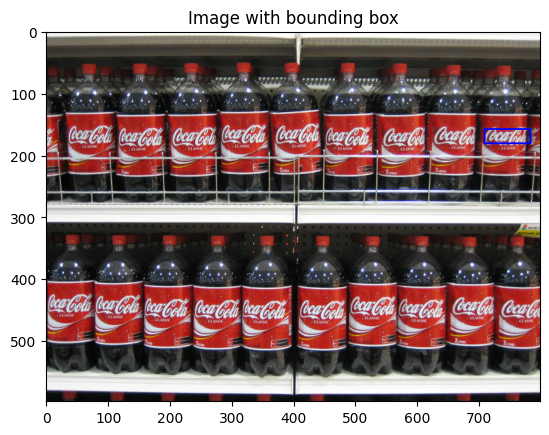

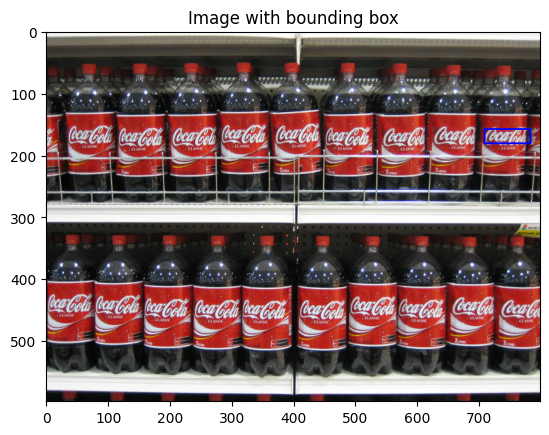

In [33]:
# Analisis de las distintas metricas disponibles: 

# Los 6 métodos posibles para comparación:
methods = [cv.TM_CCOEFF, cv.TM_CCOEFF_NORMED, cv.TM_CCORR,
            cv.TM_CCORR_NORMED, cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]

for image_name in os.listdir('data/images'):
    coca_image = cv.imread(f'data/images/coca_multi.png')
    selected_template = croped_template_canny # cropped_template_canny, croped_template_mask

    ### Notas

    # coca_logo_1 y 2: cv.TM_CCORR_NORMED 0.05 0.65
    # coca_multi = cv.TM_CCOEFF_NORMED
    # coca_retro_1 y 2 = cv.TM_CCORR_NORMED
    # COCA-COLA-LOGO = cv.TM_CCOEFF
    # logo_1: 

    matched_img = get_matching(image=coca_image, template=selected_template, method=cv.TM_CCORR_NORMED, mask = croped_template_mask)

    plt.figure()
    plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
    plt.title("Image with bounding box")

Text(0.5, 1.0, 'Image with detection')

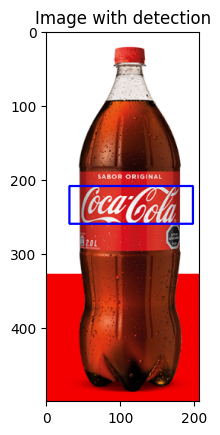

In [16]:
# Imagen 1: coca_logo_1.png

image_name = 'coca_logo_1.png'
method = cv.TM_CCORR
res_range = (0.05, 0.65)
image = cv.imread(f'data/images/{image_name}')

selected_template = croped_template_canny

matched_img = get_matching(image=image, template=selected_template, method=method, res_range=res_range)

plt.figure()
plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
plt.title("Image with detection")

Text(0.5, 1.0, 'Image with detection')

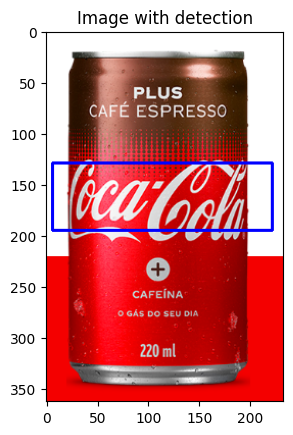

In [21]:
image_name = 'coca_logo_2.png'
method = cv.TM_CCORR
res_range = (0.05,0.65)
image = cv.imread(f'data/images/{image_name}')

selected_template = croped_template_canny

matched_img = get_matching(image=image, template=selected_template, method=method, res_range=res_range)

plt.figure()
plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
plt.title("Image with detection")

Text(0.5, 1.0, 'Image with detection')

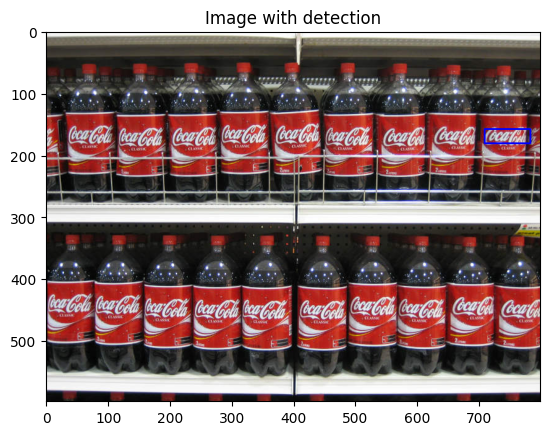

In [25]:
image_name = 'coca_multi.png'
method = cv.TM_CCORR_NORMED
res_range = (0.2,1.4)
image = cv.imread(f'data/images/{image_name}')

selected_template = croped_template_canny

matched_img = get_matching(image=image, template=selected_template, method=method, res_range=res_range)

plt.figure()
plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
plt.title("Image with detection")

Text(0.5, 1.0, 'Image with detection')

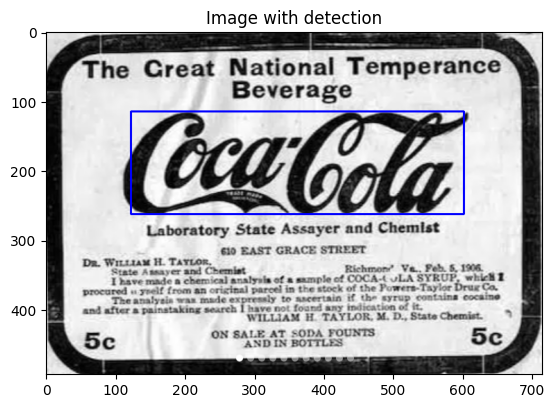

In [33]:
image_name = 'coca_retro_1.png'
method = cv.TM_CCOEFF
res_range = (0.2, 1.3)
image = cv.imread(f'data/images/{image_name}')

selected_template = croped_template_canny

matched_img = get_matching(image=image, template=selected_template, method=method, res_range=res_range)

plt.figure()
plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
plt.title("Image with detection")

Text(0.5, 1.0, 'Image with detection')

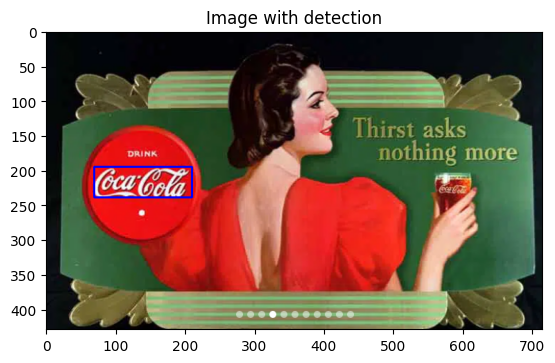

In [35]:
image_name = 'coca_retro_2.png'
method = cv.TM_CCOEFF
res_range = (0.05, 0.65)
image = cv.imread(f'data/images/{image_name}')

selected_template = croped_template_canny

matched_img = get_matching(image=image, template=selected_template, method=method, res_range=res_range)

plt.figure()
plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
plt.title("Image with detection")

Text(0.5, 1.0, 'Image with detection')

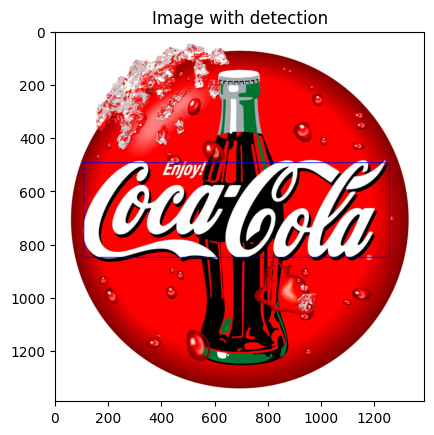

In [48]:
image_name = 'COCA-COLA-LOGO.jpg'
method = cv.TM_CCOEFF
res_range = (2, 4)
image = cv.imread(f'data/images/{image_name}')

selected_template = croped_template_canny

matched_img = get_matching(image=image, template=selected_template, method=method, res_range=res_range)

plt.figure()
plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
plt.title("Image with detection")

Text(0.5, 1.0, 'Image with detection')

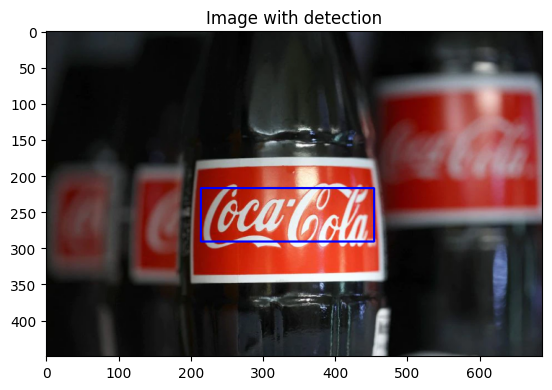

In [50]:
image_name = 'logo_1.png'
method = cv.TM_CCOEFF
res_range = (0.05, 0.65)
image = cv.imread(f'data/images/{image_name}')

selected_template = croped_template_canny

matched_img = get_matching(image=image, template=selected_template, method=method, res_range=res_range)

plt.figure()
plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
plt.title("Image with detection")

Se observa que para lograr la deteccion correcta en todas las imagenes, fue necesario modificar parametros en la mayoria de los casos

### Ejercicio 2: 
Detectar todos los logos de coca cola en la imagen coca_multi.png

In [51]:
def get_thresholded_matching(image, template, method, confidence_threshold = 0.2, nms_threshold = 0.3,mask = None):

    if len(template.shape)>2:
        template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

    
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image_gray = cv.GaussianBlur(image_gray, (7,7), 0)
    image_canny = cv.Canny(image_gray, 50, 200)

    w, h = image_gray.shape
    img_salida = image.copy()

    # Aplicamos la coincidencia de patrones para un rango de resoluciones del filtro
    #--------------------------------------
    scale_factors = np.linspace(0.2, 1.4, num=50)
    bbox_list = []
    conf_list = []
    for scale in scale_factors:
        
        template_canny_resized = cv.resize(template, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA)
        
        if template_canny_resized.shape[0] > w  or template_canny_resized.shape[1] > h:
            continue
        
        result = cv.matchTemplate(image_canny, template_canny_resized, method)

        true_loc_array = np.where(result > confidence_threshold)

        true_val_list = result[true_loc_array].tolist()

        true_loc_list = list(zip(*true_loc_array[::-1])) # [(x, y)]
        
        for idx, true_loc in enumerate(true_loc_list):
            # Store possitive bbox as ((x, y), confidence, w_bbox, h_bbox)
            h_resize, w_resize = template_canny_resized.shape
            bbox_list.append([int(true_loc[0]), 
                              int(true_loc[1]), 
                              int(w_resize), 
                              int(h_resize)])
        conf_list.extend(true_val_list) 
                
    # Perform Non-Maximum Suppression
    indices = cv.dnn.NMSBoxes(bbox_list, conf_list, confidence_threshold, nms_threshold)

    # Filter the bounding boxes and confidences based on the NMS result
    nms_boxes = [bbox_list[i] for i in indices]
    nms_confidences = [conf_list[i] for i in indices]
    
    for idx, bbox in enumerate(nms_boxes):
        (top_x, top_y, w_out, h_out) = bbox
        (end_x, end_y) = (int(top_x + w_out), int(top_y + h_out))
        conf = nms_confidences[idx]
        cv.rectangle(img_salida, (top_x, top_y), (end_x, end_y), (255, 0, 0), 2)
        text = f"{conf:.2f}"
        cv.putText(img_salida, text, (top_x, top_y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return img_salida

Text(0.5, 1.0, 'Image with bounding box')

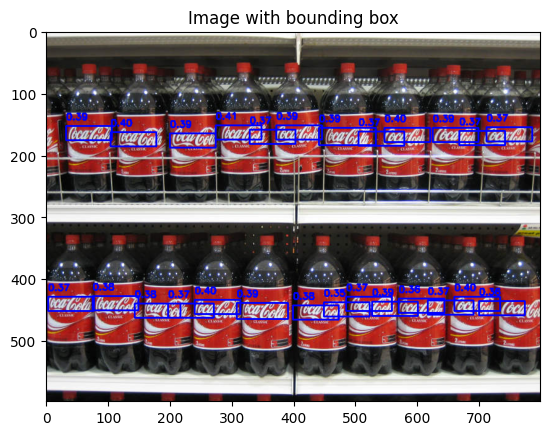

In [52]:
# Los 6 métodos posibles para comparación:

coca_multi_image = cv.imread(f'data/images/coca_multi.png')
selected_template = croped_template_canny 


matched_img = get_thresholded_matching(image=coca_multi_image, 
                                       template=selected_template, 
                                       method=cv.TM_CCORR_NORMED, 
                                       confidence_threshold=0.35,
                                       nms_threshold = 0.2)

plt.figure()
plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
plt.title("Image with bounding box")

### Ejercicio 3: 

Generalizar el algoritmo del ejercicio 2 a todas las imagenes

In [9]:
def get_generalized_thresholded_matching(image, template, method, confidence_threshold = 0.2, nms_threshold = 0.3,mask = None):

    if len(template.shape)>2:
        template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

    
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image_gray = cv.GaussianBlur(image_gray, (7,7), 0)

    w, h = image_gray.shape
    img_salida = image.copy()

    # Aplicamos la coincidencia de patrones para un rango de resoluciones del filtro
    #--------------------------------------
    scale_factors = np.linspace(0.2, 3, num=50)
    bbox_list = []
    conf_list = []
    
    # Use different sigmas for canny : 
    sigmas = np.linspace(100, 800, num=5)
    for sigma in sigmas:
        image_canny = cv.Canny(image_gray, 100, sigma)
        for scale in scale_factors:
            
            template_canny_resized = cv.resize(template, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA)
            
            if template_canny_resized.shape[0] > w  or template_canny_resized.shape[1] > h:
                continue
            
            result = cv.matchTemplate(image_canny, template_canny_resized, method)

            true_loc_array = np.where(result > confidence_threshold)

            true_val_list = result[true_loc_array].tolist()

            true_loc_list = list(zip(*true_loc_array[::-1])) # [(x, y)]
            
            for idx, true_loc in enumerate(true_loc_list):
                # Store possitive bbox as ((x, y), confidence, w_bbox, h_bbox)
                h_resize, w_resize = template_canny_resized.shape
                bbox_list.append([int(true_loc[0]), 
                                int(true_loc[1]), 
                                int(w_resize), 
                                int(h_resize)])
            conf_list.extend(true_val_list) 
                
    # Perform Non-Maximum Suppression
    indices = cv.dnn.NMSBoxes(bbox_list, conf_list, confidence_threshold, nms_threshold)

    # Filter the bounding boxes and confidences based on the NMS result
    nms_boxes = [bbox_list[i] for i in indices]
    nms_confidences = [conf_list[i] for i in indices]
    
    for idx, bbox in enumerate(nms_boxes):
        (top_x, top_y, w_out, h_out) = bbox
        (end_x, end_y) = (int(top_x + w_out), int(top_y + h_out))
        conf = nms_confidences[idx]
        cv.rectangle(img_salida, (top_x, top_y), (end_x, end_y), (255, 0, 0), 2)
        text = f"{conf:.2f}"
        cv.putText(img_salida, text, (top_x, top_y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return img_salida

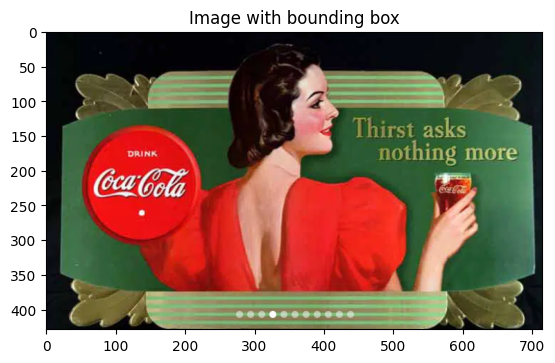

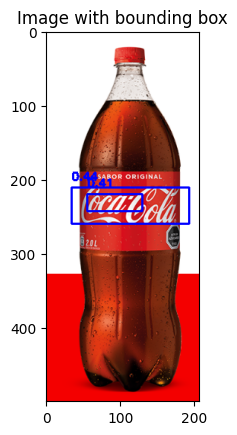

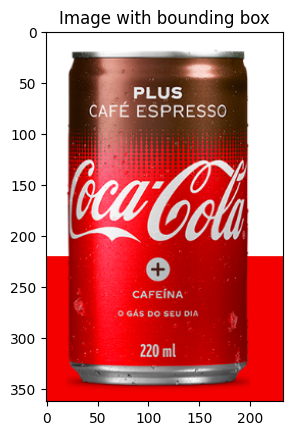

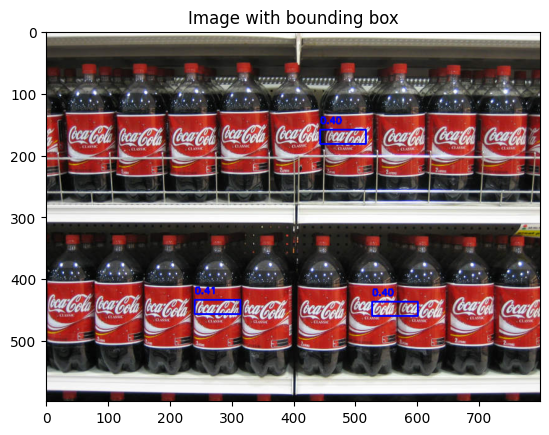

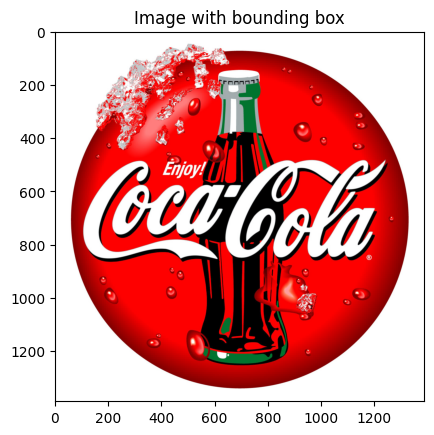

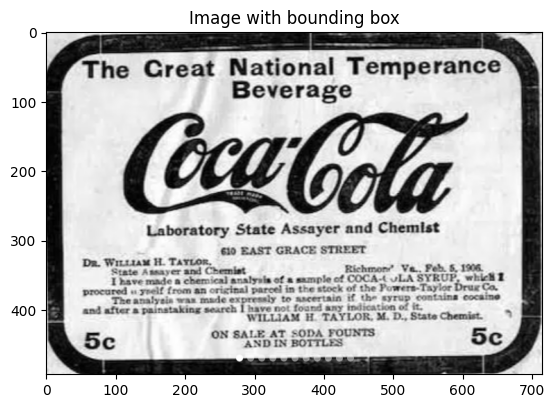

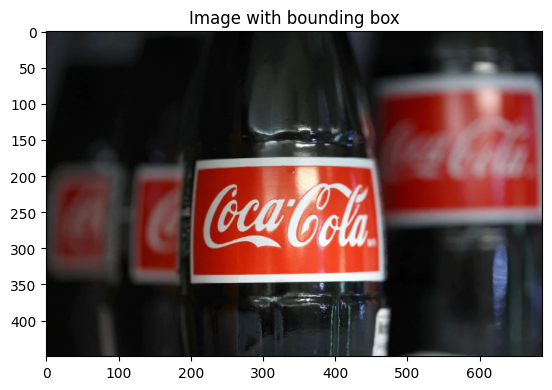

In [10]:
for image_name in os.listdir('data/images/'):
    image = cv.imread(f'data/images/{image_name}')
    selected_template = croped_template_canny 


    matched_img = get_generalized_thresholded_matching(image=image, 
                                        template=selected_template, 
                                        method=cv.TM_CCORR_NORMED, 
                                        confidence_threshold=0.4,
                                        nms_threshold = 0.3)

    plt.figure()
    plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
    plt.title("Image with bounding box")